In [1]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.0 MB/s eta 0:00:000m eta -:--:--


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import random

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
# from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

2024-02-03 09:36:00.340602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 09:36:00.340665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 09:36:00.361669: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 09:36:00.422776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 09:36:03.378803: W tensorflow/compiler/tf2

# Data Augmentation

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = './augmented_split/train/',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 1436 images belonging to 20 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = './augmented_split/val/',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 67 images belonging to 20 classes.


In [5]:
train_dir = "augmented_split/train"
val_dir = "augmented_split/val"
test_dir = "augmented_split/test"

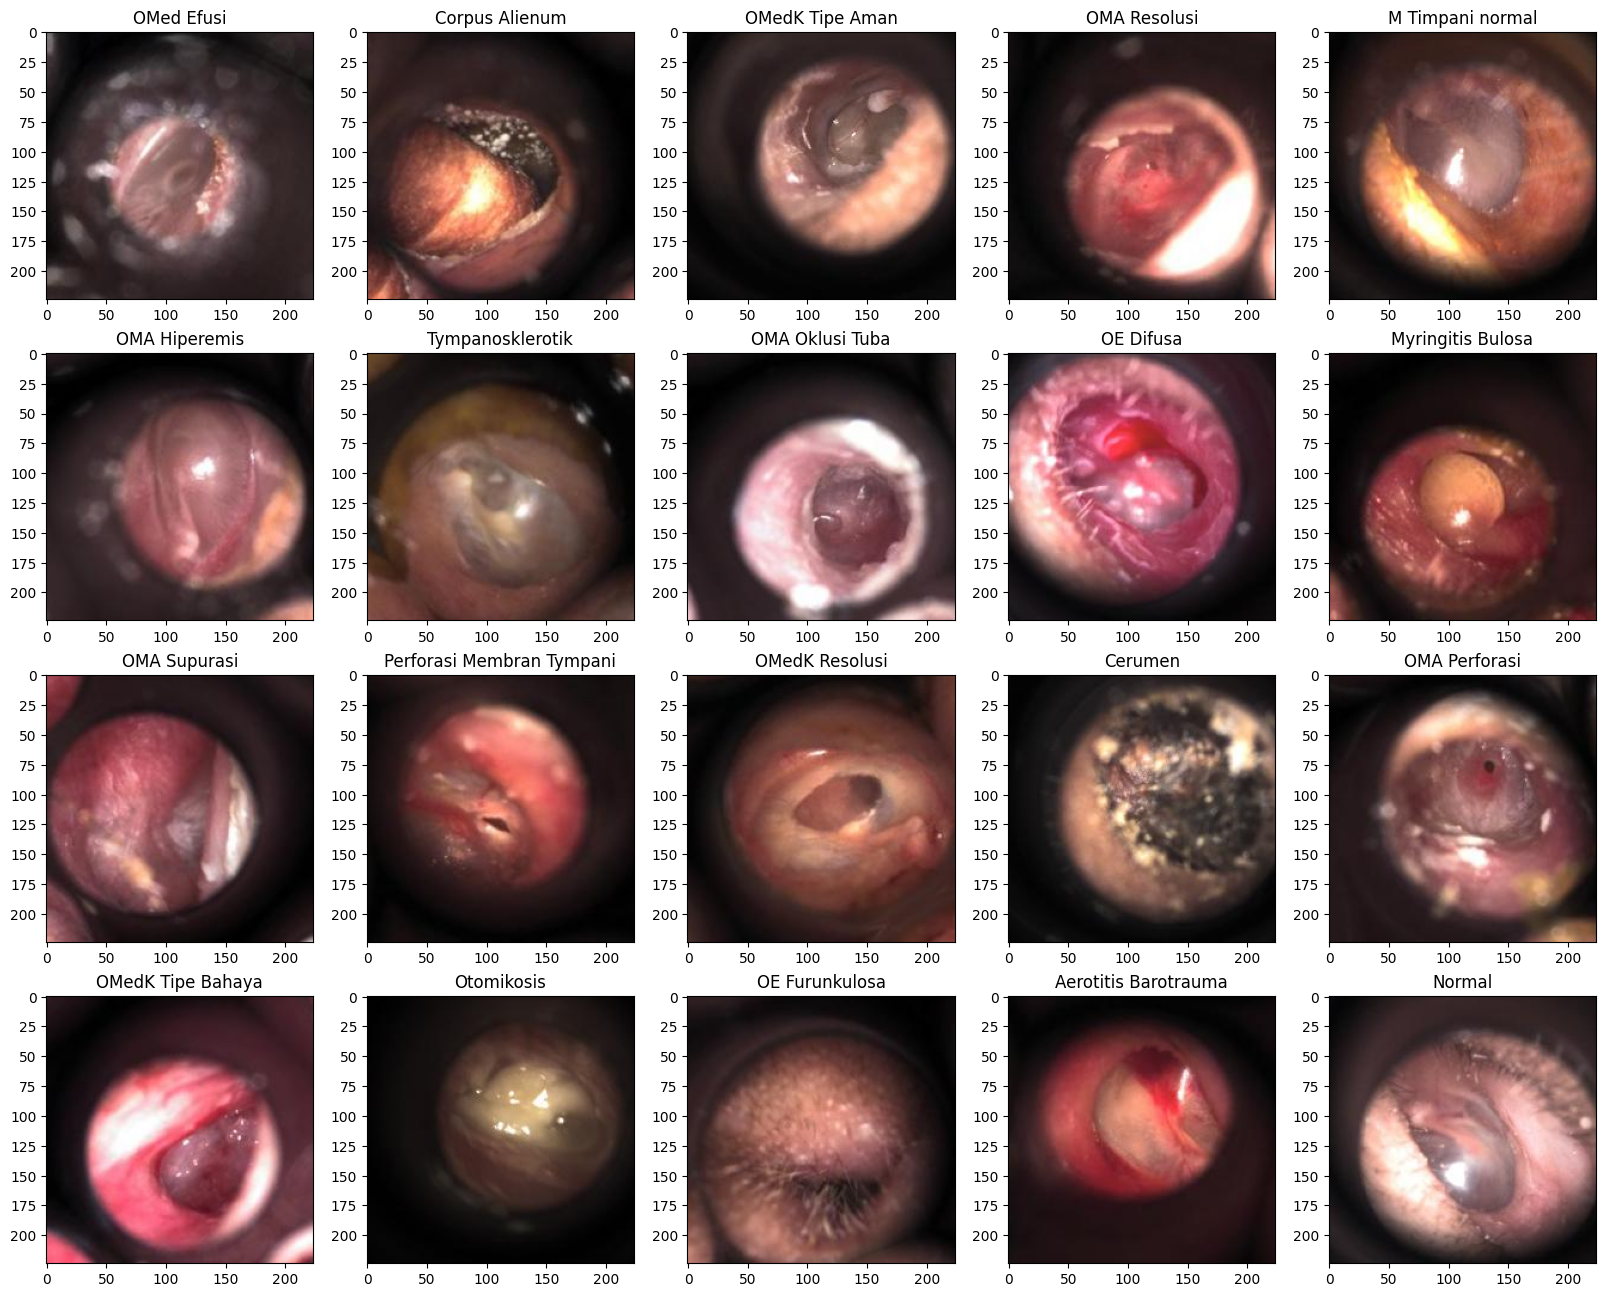

In [6]:
# dataset exploration
# load salah satu citra dari masing masing class yang ada, dan menjadikannya sebagai sebuah tensor
explor_data = []
labels = []
for label in os.listdir(test_dir): #loop masing masing class
  path = test_dir+'/'+label
  img_paths = os.listdir(path)
  random.shuffle(img_paths)
  img_path = path+'/'+img_paths[0]
  img = plt.imread(img_path) #load image
  explor_data.append(img) #masukan citra kedalam list
  labels.append(label) #masukan encoded label kedalam list

explor_data = np.array(explor_data)
explor_data.shape

plt.figure(figsize=(20,16))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.title(labels[i])
  plt.imshow( explor_data[i] )

In [7]:
base_model = enet.EfficientNetB7(input_shape=(224,224,3), 
                                 include_top=False,
                                 weights="imagenet")

2024-02-03 09:36:13.408588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 09:36:13.747245: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 09:36:13.747605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
for layer in base_model.layers:
    layer.trainable=False

In [9]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(20,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functiona  (None, 7, 7, 2560)        64097680  
 l)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 3, 2560)        0         
 Pooling2D)                                                      
                                                                 
 batch_normalization (Batch  (None, 3, 3, 2560)        10240     
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 3, 3, 2560)        0         
                                                                 
 flatten (Flatten)           (None, 23040)             0         
                                                        

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [12]:
filepath = './10-model_tuning224_128_RMSprop1e3.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100


2024-02-03 09:36:43.579637: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-03 09:36:49.116949: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-03 09:36:52.564221: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:504] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-12.2
  /usr/local/cuda
  /home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/tensorflow/python/platform/..

UnknownError: Graph execution error:

Detected at node sequential/efficientnet-b7/stem_activation/Sigmoid defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1046, in launch_instance

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_28630/849270708.py", line 1, in <module>

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/layers/core/activation.py", line 59, in call

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/efficientnet/model.py", line 115, in swish

  File "/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/backend.py", line 5915, in sigmoid

JIT compilation failed.
	 [[{{node sequential/efficientnet-b7/stem_activation/Sigmoid}}]] [Op:__inference_train_function_49561]

In [ ]:
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 64)         1728      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 64)         256       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 64)         0         ['stem_bn[0][0]'

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

NameError: name 'model_history' is not defined

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

NameError: name 'model_history' is not defined

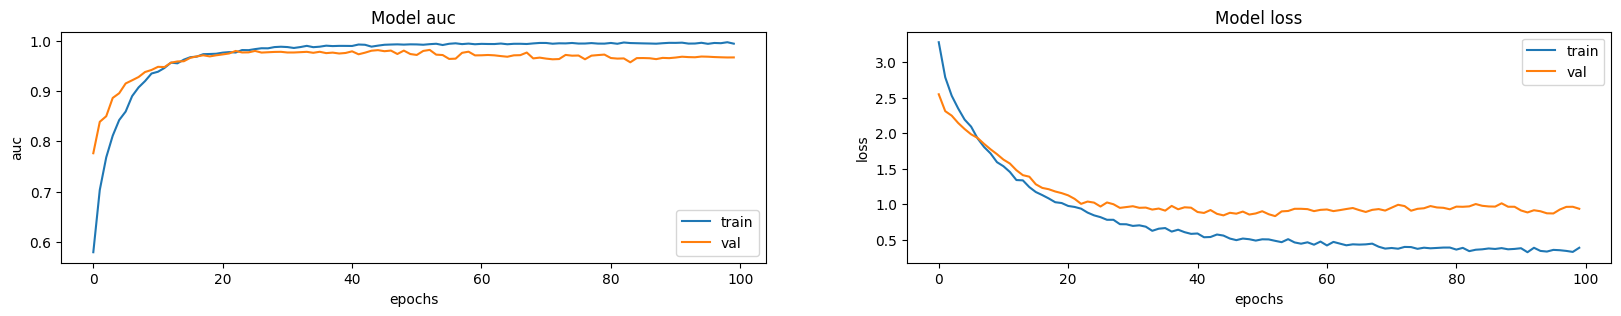

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = './augmented_split/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 401 images belonging to 20 classes.


In [ ]:
model.evaluate(test_dataset)

7/7 [==============================] - 8s 1s/step - loss: 0.9356 - auc: 0.9705


[0.9355534315109253, 0.9705206155776978]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
99.99 % chances are there that the image is NonDemented


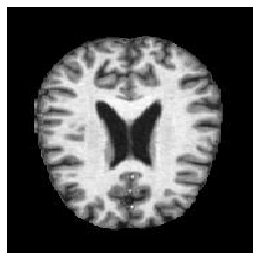

In [33]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

72.44 % chances are there that the image is MildDemented


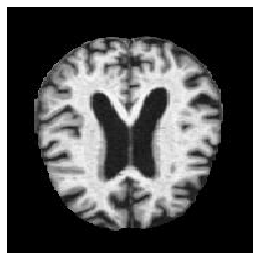

In [34]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

100.0 % chances are there that the image is ModerateDemented


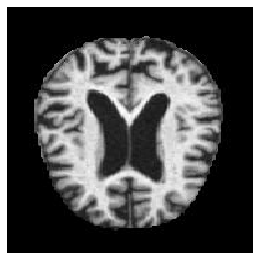

In [35]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.99 % chances are there that the image is VeryMildDemented


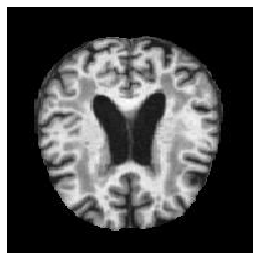

In [36]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

In [37]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

In [26]:
pred_ls = np.argmax(test_dataset, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

MemoryError: Unable to allocate 36.8 MiB for an array with shape (64, 224, 224, 3) and data type float32